# Exercise 2 - Deep Neural Networks

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID:
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the assigned project and the drafting of this notebook. 

---

## Import modules and custom libraries

In [2]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.model_selection     import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics             import confusion_matrix

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 




# ricordiamoci di togliere gli auto-import e di metterli normali
%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils
%aimport gridsearch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0 - Generate data

Let us first introduce data, namely how we generate it and how we label it. 

We uniformly sample $N=5000$ examples $x \in [-50,\,+50] \times [-50,\,+50] \equiv \mathcal{D}$. Then we apply the following labeling function:

$$
    f(x) = 
    \begin{cases}
    1 & \text{if} & x_1 > -20 \,\land\, x_2 > -40 \,\land\, x_1+x_2 < 40 \\
    0 && \text{otherwise}
    \end{cases}
$$

We show here a figure in which data is plotted and color-coded with its label. On top of that, we also show labeling boundaries (in orange) to better visualize the underlying labeling criterion.

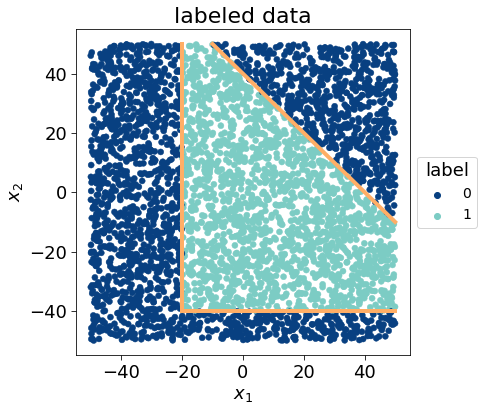

In [ ]:
# number of data
N = 4000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    palette         = "GnBu_r",
    hue_norm        = (0, 2),
    fontsize        = 18, 
    show_boundaries = True
)

plt.show()

## 1 - Study the performance of the DNN when the number N of samples is
### a) reduced
### b) increased 
### c) augmented

## 2 - Implement a “grid search” to improve one or more of the aspects or parameters of the model

### 2.1 - Preparing data

In [ ]:
## RE SCALING DATA
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

x_scaled = preprocess.standardize(x, mean, std)

## SPLIT TRAIN  VALID AND TEST -> da vedere se mettere univoco all'inizio o cosa
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

x_train, y_train = np.copy(x_scaled[:train_idx]),  np.copy(y_true[:train_idx])
x_valid, y_valid = np.copy(x_scaled[train_idx:valid_idx]), np.copy(y_true[train_idx:valid_idx])
x_test,  y_test  = np.copy(x_scaled[valid_idx:test_idx]), np.copy(y_true[valid_idx:test_idx])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]} \nN_test :\t{x_test.shape[0]}")


N_train :	2240 
N_valid :	560 
N_test :	1200


### 2.2 - Define NN and its architecture

In [ ]:
def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    hidden_activation = "relu",
    batch_norm_arc    = None,
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

In [ ]:
minibatch = 50
N_epochs  = 100 # comment lower number of epochs for a speed up in optimization

model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

### 2.3 - Grid Search CV

We now implement a grid search in order to tune the network hyperparameters. Optimization is performed splitting the hyperparameter space in three clusters:

1. optimizer, loss, hidden activation function
2. shape of the network & number of total neurons, dropout architecture, dropout rates
3. epochs, batch size  

and proceeding as follow:

- perform a grid search over each single parameter of the cluster, refine the default model with the best found value
- taking into accounts the values within a $\sigma$ of the best value for each parameter re-run a grid search for all the parameters of the given cluster, re-fine the model with the new best values
- repeat the procedure for the other clusters


#### 2.3.1
spiega tra quali valori hai scelto 

In [ ]:
## OPTIMIZER
optimizer  = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Nadam', 'Adamax', 'Ftrl']
param_grid = dict(optimizer = optimizer)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = "optimizer"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(optimizer='Nadam')

In [ ]:
## HIDDEN ACTIVATION
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh', 'softmax', 'softsign', 'softplus', 'selu']
param_grid        = dict(hidden_activation         = hidden_activation)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = "hidden_activation"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu')

In [ ]:
## LOSS
# check default loss
loss = ['binary_crossentropy']
param_grid = dict(loss = loss)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
default_loss_grid = grid.get_result()

In [ ]:
grid.print_result()

In [ ]:
# try hinge losses
loss = ['hinge', 'squared_hinge']
param_grid = dict(loss = loss)
y_train_hinge = y_train
y_train_hinge[y_train_hinge==0]=-1
grid = GridSearch(x_train, y_train_hinge, model_gridsearch, param_grid)
hinge_losses_grid = grid.get_result()

In [ ]:
# merge results for overall results
grid.print_result()

key = "loss"

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## 1- TOT GRIDSEARCH
optimizer         = ['RMSprop', 'Adamax', 'Nadam', 'Adam']
hidden_activation = ['relu', 'tanh']

param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["hidden_activation", "optimizer"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(hidden_activation='relu', optimizer='Nadam')

#### 2.3.2

In [ ]:
## DIFFERENT NN SHAPES
neurons        = [ [20,20,1], [4 for i in range(10)]+[1], [6 for i in range(6)]+[1]]

param_grid = dict(neurons        = neurons)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## DIFFERENT N of NEURONS
neurons        = [[5,5,1], [20,20,1], [100,100,1], [500,500,1]]
param_grid = dict(neurons        = neurons)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["neurons"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = True,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(neurons=[100, 100, 1])

In [ ]:
## DROPOUT PARAMS
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]

param_grid = dict(dropout_rates        = dropout_rates,
                  dropout_arc          = dropout_layers)
grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
## 2- TOT GRID
neurons              = [[100, 100,1], [20,20,1], [500,500,1]]
dropout_rates        = [[i/10] for i in range(6)]
dropout_layers       = [[1], [2]]

param_grid = dict(neurons        = neurons,
                  dropout_rates  = dropout_rates,
                  dropout_arc    = dropout_layers)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["neurons", "dropout_arc", "dropout_rates"]

fig = plt.figure(figsize=(18,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(dropout_arc=[1], dropout_rates=[0.2], neurons=[20, 20, 1])

#### 2.3.3 -

In [ ]:
## EPOCHS
N_epochs        = [10, 50, 100, 200, 300, 400]

param_grid = dict(epochs        = N_epochs)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(epochs=300)

In [ ]:
## BATCH_SIZE
minibatch        = [N_train, 50, 100, 250, 500 , 1000]

param_grid = dict(batch_size        = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["batch_size"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    #colors     = palette,
    #labels     = " ",
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(batch_size=50)

In [ ]:
## 3- TOT GRID
N_epochs         = [400, 300, 200]
minibatch        = [50, 100, 250, 500]


param_grid = dict(epochs     = N_epochs,
                  batch_size = minibatch)

grid = GridSearch(x_train, y_train, model_gridsearch, param_grid)
grid.get_result()

In [ ]:
grid.print_result()

key = ["batch_size", "epochs"]

fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = [grid.grid_result],
    fig        = fig,
    fontsize   = 18,
    legend     = False,
    title      = f"GridSearch : {key}",
    key        = key,
    fill_box   = True,
    legend_title = None
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

In [ ]:
model_gridsearch = model_gridsearch.set_params(epochs=400, batch_size=100)

### 2.4 Test score with tuned hyperparameters

In [ ]:
# check current model
model_gridsearch.get_params()

In [ ]:
fit = model_gridsearch.fit(x_train, y_train, validation_data=(x_valid, y_valid), verbose=0)

In [ ]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train")
ax.plot(fit.history['val_accuracy'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax=AX[1]
ax.plot(fit.history['loss'],label="train")
ax.plot(fit.history['val_loss'],label="valid.")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
y_pred =model_gridsearch.predict(x_test)

pred_binary = y_pred.copy()
pred_binary[y_pred <= 0.5] = 0
pred_binary[y_pred >  0.5] = 1

cm = confusion_matrix(y_test, plot_utils.flatten(pred_binary))

In [ ]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)

ax = fig.add_subplot(121)

total_0, total_1 =  np.sum(cm, axis=1)
 
cm_norm_0 = cm[0]/total_0
cm_norm_1 = cm[1]/total_1

cm_norm = np.vstack((cm_norm_0, cm_norm_1))

plot_utils.plot_confusion_matrix(
    cm = cm,
    ax = ax,
    title = "confusion matrix"
)

# scale back x data
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

ax  = plot_utils.plot_labeled_data(
        x               = x_test*std+mean, 
        labels          = plot_utils.flatten(y_pred), 
        fig             = fig, 
        subplot_id      = 122,
        title           = "DNN prediction", 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
plot_utils.boundaries(ax)
    
plt.show()

## 3 - Check whether any other rescaling of data or initialization of weights may improve the accuracy of the DNN

### Data rescalings

Next, we create identical copies of our dataset and apply a different data rescaling to each one of them. This way, we can test our model behaviour under a change in mean and variance of the same data. 

We thus define three data rescalings, with their implementation located in ```preprocess.py```:

1) No rescaling
2) Standardization
3) Normalization

The first one is as straightforward as it seems: we simply do not apply any rescaling to our data to see whether rescaling input data is relevant to achieve a satisfactory result. The second one, standardization, is probably the most common rescaling scenarios on this kind. It can be translated into a function $std(x)$ as follows:

$$
    x' = std(x) = \frac{x-\bar{x}}{\sigma(x)}
$$

where $\sigma(x)$ is a vector whose components are the standard deviations of $x$ along each of its dimensions. 

The last one instead, normalization, is a simple shift and shrink to fit data into a $\mathcal{D}'\equiv [0,\,1]\times[0,\,1]$ box, namely:

$$
    x' = norm(x) = \frac{x-x_{\text{min}}}{|x_{\text{max}}-x_{\text{min}}|}
$$

where $x_{\text{min}}$ and $x_{\text{max}}$ are vectors of the minimum and maximum values of the input dataset, along each of its dimension, respectively.

A visual representation of the three different input datasets is shown below. 

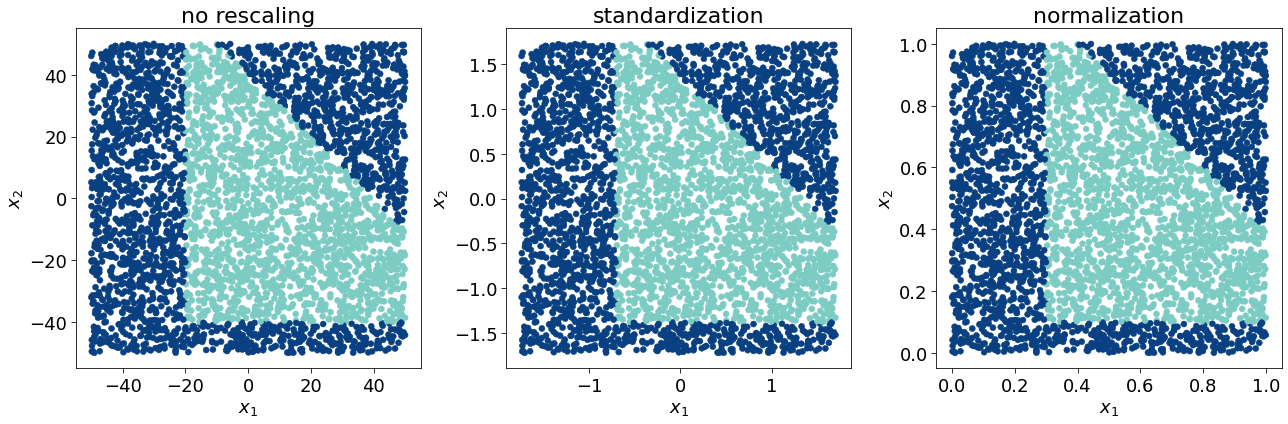

In [ ]:
mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6), constrained_layout=True)

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 18, 
        legend          = False 
    )
plt.show()

#### Training, test, validation

Now that we have the three differently rescaled datasets we split each of them into three subsets: *training set*, *validation set* and *test set*. These three subsets of the input data are used in different steps of the neural network implementation, namely training, validating and testing the model. 

The key feature of these three subsets is that they are disjoint sets, i.e. they do not share *any* example $x\in\mathcal{D}$ and thus $\mathcal{D}_{\text{train}} \cap \mathcal{D}_{\text{valid}} \cap \mathcal{D}_{\text{test}} = \emptyset$.

In [ ]:
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])

#### Neural network hyper-parameters

Now we start implementing the neural network model. First, we define its hyperparameters as the best values we have found using GridSearchCV beforehand.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [1] 
dropout_rates     = [0.2] 
batch_norm_arc    = None   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]

minibatch = 100
N_epochs  = 400

#### Training

Then we create one model for each of the three rescalings. We train these models using the validation set for an in-training accuracy evaluation on an "unseen" data sample. 

We finally print out the end-of-training loss and accuracy on both the training set and the validation set. On top of that, at the very end of the training procedure, we evaluate the three models on the test set to get a final evaluation of performance. 

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)

After that, we plot the accuracy and the loss over the training epochs for both the training and the validation set, color-coded by data rescalings. 

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see that the standardization rescaling leads to an overall faster and more accurate model. 

### Weights and biases

Now we also plot a layer-by-layer histogram of weights and biases to check whether there are significant differences between different data rescalings.

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

We cannot detect any significant differences in the weights distributions, as they all share approximately the same range of variability. Notice that this range becomes bigger as we advance into the following layers due to the ReLU activation function. 

### Neural network predictions on *test set*

Finally, we can use our trained models to predict the labels of the test sets. This allows us to build confusion matrices and compute the *sensitivity* and *specificity* of our models. In other words, we want to quantitatively assess how well our models perform on unseen data, and we aim to do so by checking true positives, true negatives, false positives and false negatives rates. 

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

From the three confusion matrices above, we can clearly see that the "no rescaling" option leads to a high false negatives rate if compared to the other two rescalings. However, "standardization" and "normalization" lead to similar results, both sharing a low rate of false positives and false negatives. Note that "standardization" lead to no false positives (i.e. perfect detection of label 0) but a slightly higher rate of false negatives if compared to the "normalization" option. 

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

### Weights initializers

In this section we check whether different weights initializations lead to sensibily different results. 

The initializers we test are:

1) RandomNormal
2) RandomUniform
3) TruncatedNormal
4) GlorotNormal
5) GlorotUniform
6) HeNormal
7) HeUniform

A detailed description of these kernel initializers can be found [here](https://keras.io/api/layers/initializers/). 


#### Neural network hyper-parameters

Here we set the neural network hyperparameters and create a list with aliases for the weights initializers reported above.

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [2]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = [
    tf.keras.metrics.Accuracy(name="accuracy"),
]

# list of initializers 
initializer_list = [
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "glorot_normal",
    "glorot_uniform",
    "he_normal",
    "he_uniform",
    # "zeros",
    # "ones",
]

### GridSearch cross validation

Now, for each data rescaling (no rescalijg, standardiation and normalization), we exploit

1) ```sklearn.model_selection.GridSearchCV```
2) ```keras.wrappers.scikit_learn.KerasClassifier```

to implement a grid search over the weights initializers list. 

THe output of the following cell will contain the score for each kernel initializer.

In [ ]:
N_epochs  = 200
minibatch = 64

grid_search_results = []

gs_means, gs_stds, gs_params = [], [], []

predictions        = []
binary_predictions = []

confusion_matrices = []

for i in range(len(dataset)):

    model_gridsearch = KerasClassifier(
        build_fn          = nn_model.create_model, 
        input_dim         = input_dim,
        architecture      = architecture,
        epochs            = N_epochs, 
        batch_size        = minibatch
    )

    param_grid = dict(initializer = initializer_list)

    grid_search = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

    grid_result = grid_search.fit(
        training_set[i], training_labels[i],
        # batch_size = minibatch,
        verbose    = 0,
    )

    grid_search_results.append(grid_result)


    # summarize results
    print("="*30)
    print()
    print(titles[i])
    print()
    print("Best model    : %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print()

    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    gs_means.append(means)
    gs_stds.append(stds)
    gs_params.append(params)

    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))
    print()
    print("="*30)

    

    # y_pred = grid_search.predict(test_set[i])
    # predictions.append(plot_utils.flatten(y_pred))

    # pred_binary = y_pred.copy()
    # pred_binary[y_pred <= 0.5] = 0
    # pred_binary[y_pred >  0.5] = 1
    # binary_predictions.append(plot_utils.flatten(pred_binary))

    # cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    # confusion_matrices.append(cm)

### GridSearch results

To gain a better understanding of the grid search results, it is better to visualize the returned scores.

In [ ]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = plot_utils.plot_gs_results(
    gs_results = grid_search_results,
    fig        = fig,
    fontsize   = 18,
    colors     = palette,
    labels     = titles,
    legend     = True,
    title      = "GridSearch : weights initializers"
)
ax.grid(axis="y", color="k", alpha=0.2)

plt.show()

From the figure above we can clearly see that the "standardization" rescaling always outouts better accuracies and we deduce that it is the most robust data rescaling we can apply. Instead, network performance under "no rescaling" and "normalization" rescaling is more influenced by the weights initializer. Nevertheless, as we have seen in the previous section, the "normalization" rescaling gives, on average, a better result than  the "no rescaling" option. 

We can also see that if we do not apply any rescaling to our data we get more variance in network performance under different weights initializers. We thus deduce that rescaling data is necessary to get a more robust model that has a lower 

### Training the best model

Next we take the best model, i.e. we set the weights initializer to the one that had the highest accuracy in the previous grid search, and train the model again. This because when running ```sklearn.model_selection.GridSearchCV.fit()``` models created do not see the whole training set. 

In [ ]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = [2] # [1]
dropout_rates     = [0.2] # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "RMSprop"
metrics   = ["accuracy"]
initializer_list = [
    "random_uniform",
    "random_normal",
    "random_normal",
]

minibatch = 64
N_epochs  = 200

In [ ]:
networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        initializer       = initializer_list[i],
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds")

    print(f"\ntraining loss     : {fit.history['loss'][-1]:.5f}")
    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")

    print(f"\nvalid loss        : {fit.history['val_loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing")

    print(f"\ntest loss         : {test[0]:.5f}")
    print(f"test accuracy     : {test[1]:.5f}\n")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)

In [ ]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#44db34", "#cb34db"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Loss function", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2, which="both")
ax2.grid(axis="y", color="k", alpha=0.2, which="both")

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs     = N_epochs,
        loss       = fit.history["loss"],
        fig        = fig,
        ax         = ax1,
        color      = palette[titles[i]][0],
        loss_label = "loss",
        title      = "training",
        label      = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "validation",
        label  = f"{titles[i]}",
    )

ax1.set_yscale("log")

plt.show()


## ====================================================##


fig, (ax1, ax2) = plt.subplots(
    nrows              = 1, 
    ncols              = 2, 
    sharex             = "all", 
    sharey             = "all",
    figsize            = (14,6), 
    constrained_layout = True
)
fig.suptitle("Accuracy", fontsize=24)

ax1.grid(axis="y", color="k", alpha=0.2)
ax2.grid(axis="y", color="k", alpha=0.2)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["accuracy"],
        fig          = fig,
        ax           = ax1,
        color        = palette[titles[i]][0],
        metric_label = "accuracy",
        title        = "training",
        label        = f"{titles[i]}",
    )
    ax2 = plot_utils.plot_metric(
        epochs       = N_epochs,
        metric       = fit.history["val_accuracy"],
        fig          = fig,
        ax           = ax2,
        color        = palette[titles[i]][0],
        title        = "validation",
        label        = f"{titles[i]}",
    )

ax1.set_yscale("linear")

plt.show()

We see in the figures above that now the "normalization" rescaling behaves poorly. Instead, the "no rescaling" option performs quite better than the non-optimized case that has been shown in the last section. This strengthen our assumption that if we do not apply rescalings to our data we introduce a large dependence to how we initialize weights. Though if we correctly optimize the weights initializer we get a better result for the "no rescaling" option, we could still prefer to avoid such dependence and lean towards the "normalization" rescaling. Note, however, that the "standardization" rescaling is the most consistent and most accurate in any scenario. 

In [ ]:
for i, network in enumerate(networks):

    weights = network.get_weights()

    axes = plot_utils.plot_weights(
        weights  = weights,
        figsize  = (14, 18),
        suptitle = titles[i],
    )

    plt.show()

In the previous histograms of weights we clearly see the influence of different initializers, but the overall increasing width of the histogram persists as we noticed in the last section.

### Neural network predictions

Finally we predict labels on the test set and compute confusion matrices to check the prediction performance.

In [ ]:
predictions        = []
binary_predictions = []
confusion_matrices = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(test_set[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

    cm = confusion_matrix(test_labels[i], plot_utils.flatten(pred_binary))
    confusion_matrices.append(cm)

In [ ]:
labels = [0, 1]
fontsize=18

fig = plt.figure(figsize=(15,5), constrained_layout=True)

for i, cm in enumerate(confusion_matrices):

    ax = fig.add_subplot(131+i)

    total_0, total_1 =  np.sum(cm, axis=1)
 
    cm_norm_0 = cm[0]/total_0
    cm_norm_1 = cm[1]/total_1

    cm_norm = np.vstack((cm_norm_0, cm_norm_1))

    plot_utils.plot_confusion_matrix(
        cm = cm_norm,
        ax = ax,
        title = titles[i]
    )
    

plt.show()

We clearly see here that the two best performing rescalings are "standardization" and "normalization", despite the overall worse performance of "normalization" compared to the "no rescaling" option. 

In [ ]:
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle("Real data", fontsize=24)
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle("Neural network predictions", fontsize=24)
for i in range(len(dataset)):

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = test_labels[i],
        fig             = fig1, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")

    ax = plot_utils.plot_labeled_data(
        x               = test_set[0], 
        labels          = binary_predictions[i], 
        fig             = fig2, 
        subplot_id      = 131+i,
        title           = titles[i], 
        palette         = "GnBu_r",
        hue_norm        = (0, 2),
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax, lw=1, color="w")


plt.show()

## 4 - Study different data

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>